In [1]:
# === Consolidated imports (place at the very top) ===

# stdlib
import os
import sys
import re
import warnings
import datetime as dt
from datetime import datetime, timedelta

# core data
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn: model selection
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# sklearn: metrics
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# sklearn: preprocessing
from sklearn.preprocessing import OrdinalEncoder, StandardScaler  # StandardScaler is harmless if unused

# sklearn: models (classification)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# sklearn: models (regression)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor




# style / warnings
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)
warnings.filterwarnings("ignore")


In [2]:
#setting base path
base_path = 'data/'


In [3]:
#loading files
sales = pd.read_csv(base_path + 'sales.csv')
promotion = pd.read_csv(base_path + 'promotion.csv')
item = pd.read_csv(base_path + 'item.csv')
supermarkets = pd.read_csv(base_path + 'supermarkets.csv')

In [4]:
# Renaming columns for consistency
sales.columns = ['code', 'amount', 'units', 'time', 'province', 'week',
                 'customer_id', 'supermarket', 'basket', 'day', 'voucher']

item.columns = ['code', 'description', 'type', 'brand', 'size']
promotion.columns = ['code', 'supermarket', 'week', 'feature', 'display', 'province']
supermarkets.columns = ['supermarket', 'postal_code']


In [5]:
# checking for missing values in each dataset
print("Sales missing values:")
print(sales.isnull().sum())
print("\nItem missing values:")
print(item.isnull().sum())
print("\nPromotion missing values:")
print(promotion.isnull().sum())
print("\nSupermarkets missing values:")
print(supermarkets.isnull().sum())


Sales missing values:
code           0
amount         0
units          0
time           0
province       0
week           0
customer_id    0
supermarket    0
basket         0
day            0
voucher        0
dtype: int64

Item missing values:
code           0
description    0
type           0
brand          0
size           0
dtype: int64

Promotion missing values:
code           0
supermarket    0
week           0
feature        0
display        0
province       0
dtype: int64

Supermarkets missing values:
supermarket    0
postal_code    0
dtype: int64


In [6]:
# looking at structure of sales dataset
sales.info()

# summarizing numeric columns of sales dataset
sales.describe()

# previewing first few rows of sales dataset
sales.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   code         1048575 non-null  int64  
 1   amount       1048575 non-null  float64
 2   units        1048575 non-null  int64  
 3   time         1048575 non-null  int64  
 4   province     1048575 non-null  int64  
 5   week         1048575 non-null  int64  
 6   customer_id  1048575 non-null  int64  
 7   supermarket  1048575 non-null  int64  
 8   basket       1048575 non-null  int64  
 9   day          1048575 non-null  int64  
 10  voucher      1048575 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 88.0 MB


,code,amount,units,time,province,week,customer_id,supermarket,basket,day,voucher
0,7680850106,0.80,1,1100,2,1,125434,244,1,1,0
1,3620000470,3.59,1,1100,2,1,125434,244,1,1,0
2,1800028064,2.25,1,1137,2,1,108320,244,2,1,0
3,9999985067,0.85,1,1148,2,1,162016,244,3,1,0
4,9999985131,2.19,1,1323,2,1,89437,244,4,1,0


In [7]:
# checking for duplicate rows
print("duplicate rows in sales:", sales.duplicated().sum())

# checking for negative or zero sales amounts
print("amount value counts (sample):")
print(sales['amount'].value_counts().head(10))

# checking range of units
print("\nunits min and max:", sales['units'].min(), sales['units'].max())

# checking unique values of day column
print("\nday unique values:", sales['day'].unique())

# checking unique values of voucher column
print("\nvoucher unique values:", sales['voucher'].unique())

# checking unique values of province column
print("\nprovince unique values:", sales['province'].unique())

# checking unique values of supermarket column (first 20 only)
print("\nsupermarket unique sample:", sales['supermarket'].unique()[:20])

# checking min and max time values
print("\ntime min and max:", sales['time'].min(), sales['time'].max())


duplicate rows in sales: 0
amount value counts (sample):
amount
0.99    113373
1.99     68498
1.19     51427
1.50     50129
0.79     44778
2.19     26998
1.98     24624
2.00     24323
1.29     23727
0.67     23423
Name: count, dtype: int64

units min and max: 1 100

day unique values: [  1   2   3   4   5   7   6   8   9  11  10  13  14  12  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  35  34  36
  37  38  40  39  41  42  43  44  45  46  47  48  49  50  51  52  53  55
  54  56  57  58  59  60  61  62  63  65  64  66  67  68  69  71  70  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  90  89
  91  92  93  94  95  97  96  98  99 100 101 103 102 105 104 106 107 108
 109 110 112 111 113 114 115 116 117 118 119 120 121 122 123 124 154 153
 155 156 157 158 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195]

voucher unique values: [0 1]

province

In [8]:
# looking at structure of item dataset
item.info()

# summarizing numeric columns of item dataset
item.describe()

# previewing first few rows of item dataset
item.head()

# checking unique values in type column
print("unique values in type:", item['type'].unique())

# checking unique values in brand column (sample 20)
print("\nunique brand sample:", item['brand'].unique()[:20])

# checking duplicates in item
print("\nduplicate rows in item:", item.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 927 entries, 0 to 926
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   code         927 non-null    int64 
 1   description  927 non-null    object
 2   type         927 non-null    object
 3   brand        927 non-null    object
 4   size         927 non-null    object
dtypes: int64(1), object(4)
memory usage: 36.3+ KB
unique values in type: ['Type 1' 'Type 2' 'Type 3' 'Type 4']

unique brand sample: ['Aunt Jemima' 'Bisquick' "Bruce's" 'Classique' 'Fastshake'
 'Hodgson Mills' 'Hungry Jack' 'Krusteaz' 'Lund Swede' 'M W Flapstax'
 'Maple Grove' 'Mrs Butterworth' 'Osem Bissli' 'Pioneer' 'Private Label'
 'Private Label Premium' 'White Lily' 'Al Dente' 'Alessi' 'Annie Chns']

duplicate rows in item: 0


In [9]:
print("unique province values:", sales['province'].unique())
print("\nunique supermarket values:", sales['supermarket'].unique())
print("\nunique voucher values:", sales['voucher'].unique())
print("\nunique day values:", sales['day'].unique())

print("unique type values:", item['type'].unique())
print("\nunique brand values:", item['brand'].unique())
print("\nunique size values:", item['size'].unique())
print("unique feature values:", promotion['feature'].unique())
print("\nunique display values:", promotion['display'].unique())
print("\nunique province values:", promotion['province'].unique())
print("unique supermarket values:", supermarkets['supermarket'].unique())
print("\nunique postal_code values:", supermarkets['postal_code'].unique())


unique province values: [2 1]

unique supermarket values: [244 365 253 352 311 314 256 344 273 228 339 379 287 252 377 359 367 308
 341 382 307 361 242 322 258 241 319 354 317 357 271 261 290 374 265 263
 381 326 375 378 270 373 257 294 371 248 324 376 305 368 264 232 336 234
 235 348 284 323 272 315 231 301 239 356 282 309 254 280 328 313 266 306
 295 233 333 343 335 372 304 281 238 279 337 347 300 363 292 288 293 302
 384 316 338 299 274 355 250 312 383 267 289 358 362 298 240 283 275 342
 369 262 320 340 227 269 351 246 318 260 364 321 350 259 291 286 332 249
 247 366 325 345 297 346 255 230 329 303 349 276 330 285 229 385 277 360
 327 380 237 243 334 353 226 133  92 154 185 190  62  13 107  17  52  63
 137 215 138  67 108 117  88 132 170 165  36 114 219   2 147 100  68  21
 169  48   7 126  84  39 128 121  76 156  43  44 118 101 193  98  61  38
 168 136  35 161  74  15  54  65 171  29 140 188 120 181  51 167  77  97
 180  79  41   4  81 192  64 195 110  49 151  34 175  14 205  25  

In [10]:
# checking if all product codes in sales exist in item
missing_items = sales[~sales['code'].isin(item['code'])]
print("rows in sales with item codes missing from item:", missing_items.shape[0])

# checking if all supermarket IDs in sales exist in supermarkets
missing_stores = sales[~sales['supermarket'].isin(supermarkets['supermarket'])]
print("rows in sales with supermarket IDs missing from supermarkets:", missing_stores.shape[0])

# checking if all codes in promotion exist in item
missing_promo_items = promotion[~promotion['code'].isin(item['code'])]
print("rows in promotion with codes missing from item:", missing_promo_items.shape[0])

# checking if all supermarkets in promotion exist in supermarkets
missing_promo_stores = promotion[~promotion['supermarket'].isin(supermarkets['supermarket'])]
print("rows in promotion with stores missing from supermarkets:", missing_promo_stores.shape[0])


rows in sales with item codes missing from item: 0
rows in sales with supermarket IDs missing from supermarkets: 0
rows in promotion with codes missing from item: 0
rows in promotion with stores missing from supermarkets: 0


In [11]:

# converting day into a base date starting at 2023-01-01
sales['date'] = pd.to_datetime("2023-01-01") + pd.to_timedelta(sales['day'] - 1, unit='D')

# extracting hour and minute from time
sales['hour'] = sales['time'] // 100
sales['minute'] = sales['time'] % 100

# creating full datetime column
sales['datetime'] = sales['date'] + pd.to_timedelta(sales['hour'], unit='h') + pd.to_timedelta(sales['minute'], unit='m')

# checking result
sales[['day', 'time', 'date', 'hour', 'minute', 'datetime']].head(10)


,day,time,date,hour,minute,datetime
0,1,1100,2023-01-01,11,0,2023-01-01 11:00:00
1,1,1100,2023-01-01,11,0,2023-01-01 11:00:00
2,1,1137,2023-01-01,11,37,2023-01-01 11:37:00
3,1,1148,2023-01-01,11,48,2023-01-01 11:48:00
4,1,1323,2023-01-01,13,23,2023-01-01 13:23:00
5,1,1323,2023-01-01,13,23,2023-01-01 13:23:00
6,1,1415,2023-01-01,14,15,2023-01-01 14:15:00
7,1,1415,2023-01-01,14,15,2023-01-01 14:15:00
8,1,1513,2023-01-01,15,13,2023-01-01 15:13:00
9,1,1523,2023-01-01,15,23,2023-01-01 15:23:00


In [12]:
# creating extra time-based features
sales['day_of_week'] = sales['datetime'].dt.dayofweek   # 0=Monday, 6=Sunday
sales['month'] = sales['datetime'].dt.month
sales['hour'] = sales['datetime'].dt.hour

# checking result
sales[['datetime', 'day_of_week', 'month', 'hour']].head(10)



,datetime,day_of_week,month,hour
0,2023-01-01 11:00:00,6,1,11
1,2023-01-01 11:00:00,6,1,11
2,2023-01-01 11:37:00,6,1,11
3,2023-01-01 11:48:00,6,1,11
4,2023-01-01 13:23:00,6,1,13
5,2023-01-01 13:23:00,6,1,13
6,2023-01-01 14:15:00,6,1,14
7,2023-01-01 14:15:00,6,1,14
8,2023-01-01 15:13:00,6,1,15
9,2023-01-01 15:23:00,6,1,15


In [13]:
# adding more time-based features
sales['day_of_week'] = sales['datetime'].dt.dayofweek   # 0=Monday ... 6=Sunday
sales['month'] = sales['datetime'].dt.month
sales['is_weekend'] = sales['day_of_week'].isin([5,6]).astype(int)  # 1=Saturday/Sunday
sales['hour_bucket'] = pd.cut(sales['hour'], bins=[-1,5,11,17,23], labels=['Night','Morning','Afternoon','Evening'])

# checking enriched features
sales[['datetime','day_of_week','month','is_weekend','hour_bucket']].head(10)


,datetime,day_of_week,month,is_weekend,hour_bucket
0,2023-01-01 11:00:00,6,1,1,Morning
1,2023-01-01 11:00:00,6,1,1,Morning
2,2023-01-01 11:37:00,6,1,1,Morning
3,2023-01-01 11:48:00,6,1,1,Morning
4,2023-01-01 13:23:00,6,1,1,Afternoon
5,2023-01-01 13:23:00,6,1,1,Afternoon
6,2023-01-01 14:15:00,6,1,1,Afternoon
7,2023-01-01 14:15:00,6,1,1,Afternoon
8,2023-01-01 15:13:00,6,1,1,Afternoon
9,2023-01-01 15:23:00,6,1,1,Afternoon


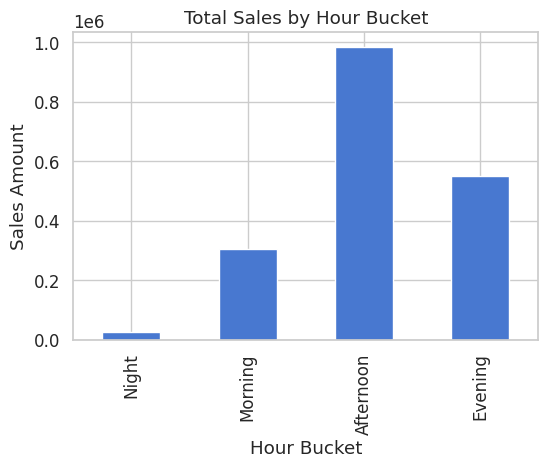

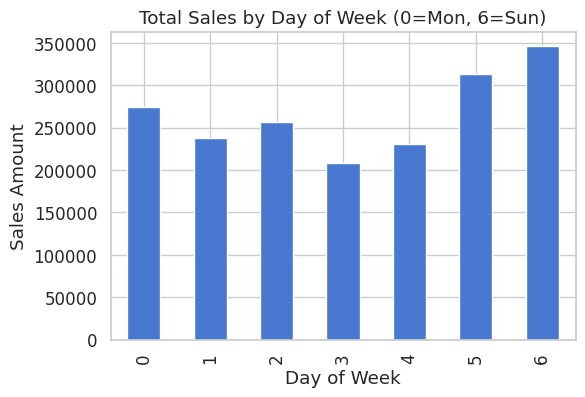

In [14]:

# aggregating basket totals by hour bucket
hourly_sales = sales.groupby('hour_bucket')['amount'].sum().sort_index()

# plotting sales by hour bucket
hourly_sales.plot(kind='bar', figsize=(6,4))
plt.title("Total Sales by Hour Bucket")
plt.ylabel("Sales Amount")
plt.xlabel("Hour Bucket")
plt.show()

# aggregating sales by day of week
weekday_sales = sales.groupby('day_of_week')['amount'].sum()

# plotting sales by day of week
weekday_sales.plot(kind='bar', figsize=(6,4))
plt.title("Total Sales by Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Sales Amount")
plt.xlabel("Day of Week")
plt.show()


In [15]:
# cleaning size into one categorical column: "<number> <unit>" like "16 OZ" / "16 FL OZ", else NaN

# making uppercase and collapsing spaces
item['size_work'] = item['size'].astype(str).str.upper().str.strip()
item['size_work'] = item['size_work'].str.replace(r'\s+', ' ', regex=True)

# marking junk as NaN (cells containing '#', 'NO TAG', 'CUST REQST')
item.loc[item['size_work'].str.contains(r'#|NO TAG|CUST REQST', na=False), 'size_work'] = np.nan

# normalizing unit words: converting OUNCE/OUNCES to OZ; keeping FL OZ distinct
item['size_work'] = (item['size_work']
    .str.replace(r'\bFL\s*OUNCES?\b', 'FL OZ', regex=True)
    .str.replace(r'\bOUNCES?\b', 'OZ', regex=True)
    .str.replace(r'\bOZ\.\b', 'OZ', regex=True)
)

# inserting missing space between number and unit (e.g., 16OZ, 3LB, 24OZ)
item['size_work'] = item['size_work'].str.replace(r'(\d)\s*(FL\s*OZ|OZ|LB|GAL)\b', r'\1 \2', regex=True)

# fixing odd 'Z' unit like '16  Z' -> '16 OZ'
item['size_work'] = item['size_work'].str.replace(r'(\d+)\s+Z\b', r'\1 OZ', regex=True)

# converting '31 1/2 OZ' -> '31.5 OZ'
item['size_work'] = item['size_work'].str.replace(r'\b(\d+)\s+1/2\b', lambda m: f"{int(m.group(1)) + 0.5}", regex=True)

# removing trailing punctuation after unit (e.g., '26 OZ.' -> '26 OZ')
item['size_work'] = item['size_work'].str.replace(r'\b(FL OZ|OZ|LB|GAL)\.?$', r'\1', regex=True)

# extracting number and unit
item['size_value'] = pd.to_numeric(item['size_work'].str.extract(r'(^|\s)(\d*\.?\d+)(?=\s)', expand=True)[1], errors='coerce')
item['size_unit']  = item['size_work'].str.extract(r'\b(FL\s*OZ|OZ|LB|GAL)\b', expand=False).str.replace(r'\s+', ' ', regex=True)

# building final 'size_category' as "<number> <unit>" with exactly one space; else NaN
item['size_category'] = np.where(
    item['size_value'].notna() & item['size_unit'].notna(),
    item['size_value'].map(lambda x: f"{x:.2f}".rstrip('0').rstrip('.')) + ' ' + item['size_unit'],
    np.nan
)

# previewing cleaned values
item[['size', 'size_category']].head(20)


,size,size_category
0,2 LB,2 LB
1,32 OZ,32 OZ
2,32 OZ,32 OZ
3,1 LB,1 LB
4,6.75 OZ,6.75 OZ
5,7 OZ,7 OZ
6,7.75 OZ,7.75 OZ
7,7 OZ,7 OZ
8,1.5 LB,1.5 LB
9,16 OZ,16 OZ


In [16]:
# checking unique values in cleaned size_category
unique_sizes = sorted(item['size_category'].dropna().unique().tolist())
print("number of unique sizes:", len(unique_sizes))
print("\nunique sizes:")
print(unique_sizes)


number of unique sizes: 70

unique sizes:
['0.5 OZ', '1 LB', '1.1 OZ', '1.5 LB', '10 OZ', '10.5 OZ', '10.6 OZ', '12 FL OZ', '12 OZ', '12.5 FL OZ', '12.5 OZ', '12.7 OZ', '13 OZ', '13.25 OZ', '14 OZ', '14.5 OZ', '15 OZ', '15.5 OZ', '16 OZ', '16.9 OZ', '17 OZ', '17.5 OZ', '17.6 OZ', '17.7 OZ', '19 OZ', '2 LB', '2.5 OZ', '2.8 OZ', '20 OZ', '23 OZ', '24 FL OZ', '24 OZ', '25 OZ', '25.3 OZ', '25.5 OZ', '25.6 OZ', '25.75 OZ', '26 OZ', '26.3 OZ', '26.5 OZ', '27.5 OZ', '27.6 OZ', '27.75 OZ', '28 OZ', '3 LB', '3.5 OZ', '31.5 OZ', '32 OZ', '36 FL OZ', '36 OZ', '37 OZ', '4 LB', '40 OZ', '45 OZ', '48 OZ', '5 OZ', '5.5 OZ', '6 LB', '6 OZ', '6.3 OZ', '6.5 OZ', '6.75 OZ', '67 OZ', '7 OZ', '7.25 OZ', '7.75 OZ', '8 OZ', '8.5 OZ', '8.8 OZ', '9 OZ']


In [17]:
# counting frequency of each size_category
size_dist = item['size_category'].value_counts().sort_values(ascending=False)

print("Number of unique sizes:", size_dist.shape[0])
print("\nTop 15 most common sizes:")
print(size_dist.head(15))


Number of unique sizes: 70

Top 15 most common sizes:
size_category
16 OZ      235
26 OZ      120
12 OZ      107
24 OZ       57
8 OZ        38
1 LB        37
32 OZ       36
10 OZ       23
7 OZ        17
48 OZ       13
2 LB        12
17 OZ       12
26.5 OZ     10
25 OZ       10
15 OZ       10
Name: count, dtype: int64


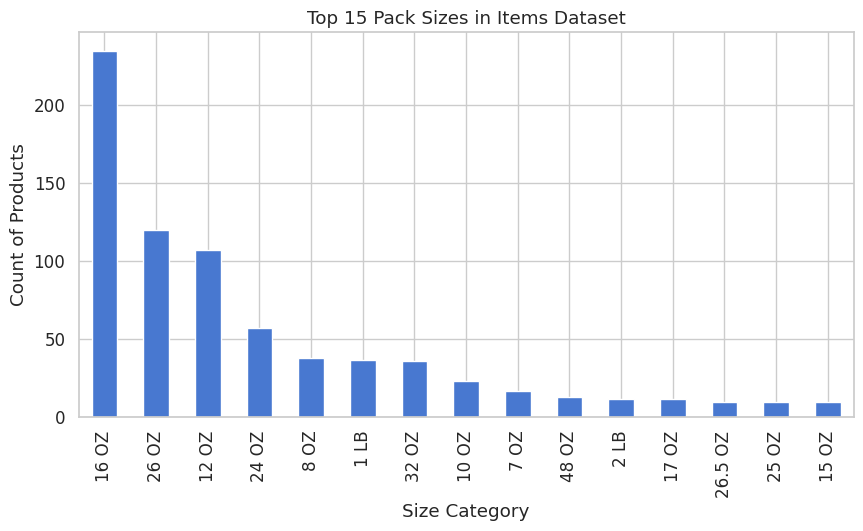

In [18]:
# plotting top 15 sizes
size_dist.head(15).plot(kind='bar', figsize=(10,5))
plt.title("Top 15 Pack Sizes in Items Dataset")
plt.ylabel("Count of Products")
plt.xlabel("Size Category")
plt.show()


In [19]:
# keeping only needed columns from item (including cleaned size_category)
item_keep = item[['code', 'description', 'type', 'brand', 'size_category']].copy()

# merging sales with item info
# (left join so we keep all sales rows)
merged = pd.merge(sales, item_keep, on='code', how='left')

# merging supermarket postal code
merged = pd.merge(merged, supermarkets, on='supermarket', how='left')

# checking shape and a quick preview
print("final merged shape:", merged.shape)
merged.head(5)


final merged shape: (1048575, 24)


,code,amount,units,time,province,week,customer_id,supermarket,basket,day,voucher,date,hour,minute,datetime,day_of_week,month,is_weekend,hour_bucket,description,type,brand,size_category,postal_code
0,7680850106,0.80,1,1100,2,1,125434,244,1,1,0,2023-01-01,11,0,2023-01-01 11:00:00,6,1,1,Morning,BARILLA ANGEL HAIR,Type 2,Barilla,16 OZ,40222
1,3620000470,3.59,1,1100,2,1,125434,244,1,1,0,2023-01-01,11,0,2023-01-01 11:00:00,6,1,1,Morning,BERTOLLI TOM&BASIL SAUCE,Type 3,Bertolli,24 OZ,40222
2,1800028064,2.25,1,1137,2,1,108320,244,2,1,0,2023-01-01,11,37,2023-01-01 11:37:00,6,1,1,Morning,H J PANCK BTRMLK COMP MIX,Type 1,Hungry Jack,NaN,40222
3,9999985067,0.85,1,1148,2,1,162016,244,3,1,0,2023-01-01,11,48,2023-01-01 11:48:00,6,1,1,Morning,PRIVATE LABEL VERMICELLI,Type 2,Private Label,16 OZ,40222
4,9999985131,2.19,1,1323,2,1,89437,244,4,1,0,2023-01-01,13,23,2023-01-01 13:23:00,6,1,1,Afternoon,PRIVATE LABEL IMPORTED LASAGNA,Type 2,Private Label Premium,16 OZ,40222


In [20]:
# checking for nulls introduced by joins (expecting none except size_category which may be NaN after cleaning)
print("\nnulls after merging (selected columns):")
print(merged[['description','type','brand','size_category','postal_code']].isnull().sum())



nulls after merging (selected columns):
description          0
type                 0
brand                0
size_category    11674
postal_code          0
dtype: int64


In [21]:
# finding the most common size
mode_size = merged['size_category'].mode()[0]
print("Most common size:", mode_size)

# filling missing values with mode
merged['size_category'] = merged['size_category'].fillna(mode_size)

# rechecking nulls
merged['size_category'].isnull().sum()


Most common size: 16 OZ


np.int64(0)

In [22]:
# FULL DATASET SUMMARY & CONSISTENCY CHECK

print("=== Structure ===")
merged.info()
print("\n")

print("=== Numeric Summary ===")
print(merged.describe())
print("\n")

print("=== Missing Values ===")
print(merged.isnull().sum().sort_values(ascending=False))
print("\n")

print("=== Duplicates ===")
print("duplicate rows:", merged.duplicated().sum())
print("\n")

print("=== Key Integrity ===")
print("unique product codes:", merged['code'].nunique())
print("unique customers:", merged['customer_id'].nunique())
print("unique supermarkets:", merged['supermarket'].nunique())
print("unique baskets:", merged['basket'].nunique())
print("\n")

print("=== Categorical Checks ===")
print("province values:", merged['province'].unique())
print("types:", merged['type'].unique())
print("number of brands:", merged['brand'].nunique())
print("number of size categories:", merged['size_category'].nunique())
print("\n")

print("=== Sales Value Consistency ===")
print("min/max amount:", merged['amount'].min(), merged['amount'].max())
print("min/max units:", merged['units'].min(), merged['units'].max())
print("rows with amount <= 0:", merged[merged['amount'] <= 0].shape[0])
print("rows with units <= 0:", merged[merged['units'] <= 0].shape[0])
print("\n")

print("=== Time Consistency ===")
print("date range:", merged['datetime'].min(), "to", merged['datetime'].max())
print("unique hours:", sorted(merged['hour'].unique()))
print("unique weekdays:", sorted(merged['day_of_week'].unique()))


=== Structure ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 24 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   code           1048575 non-null  int64         
 1   amount         1048575 non-null  float64       
 2   units          1048575 non-null  int64         
 3   time           1048575 non-null  int64         
 4   province       1048575 non-null  int64         
 5   week           1048575 non-null  int64         
 6   customer_id    1048575 non-null  int64         
 7   supermarket    1048575 non-null  int64         
 8   basket         1048575 non-null  int64         
 9   day            1048575 non-null  int64         
 10  voucher        1048575 non-null  int64         
 11  date           1048575 non-null  datetime64[ns]
 12  hour           1048575 non-null  int32         
 13  minute         1048575 non-null  int64         
 14  datetime       1

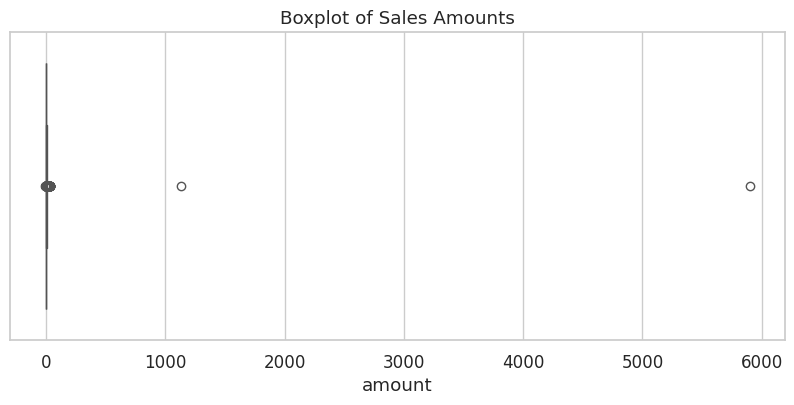

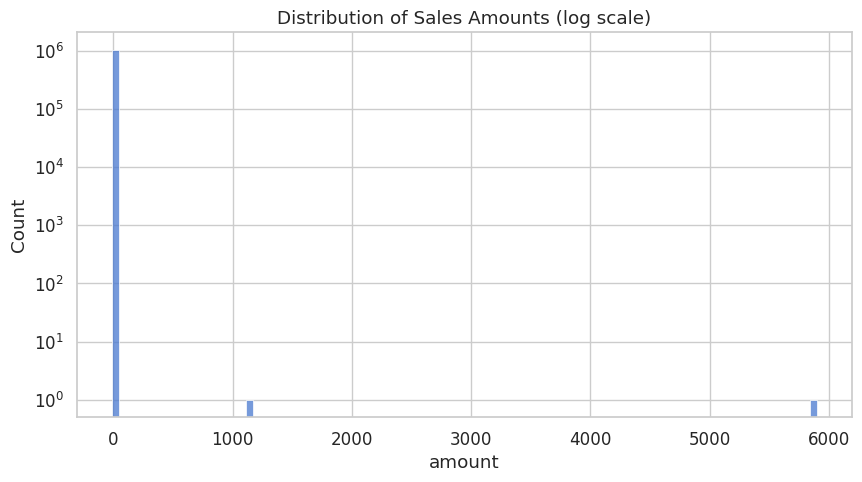

Q1: 0.99 Q3: 2.19 IQR: 1.2
Lower Bound: -0.8099999999999998 Upper Bound: 3.9899999999999998
Number of outliers: 38924
Min amount: -8.28 Max amount: 5900.0


In [23]:

# 1. Checking distribution with boxplot
plt.figure(figsize=(10,4))
sns.boxplot(x=merged['amount'])
plt.title("Boxplot of Sales Amounts")
plt.show()

# 2. Histogram with log scale to see distribution clearly
plt.figure(figsize=(10,5))
sns.histplot(merged['amount'], bins=100)
plt.yscale('log')
plt.title("Distribution of Sales Amounts (log scale)")
plt.show()

# 3. Quick stats for outliers
q1 = merged['amount'].quantile(0.25)
q3 = merged['amount'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print("Q1:", q1, "Q3:", q3, "IQR:", iqr)
print("Lower Bound:", lower_bound, "Upper Bound:", upper_bound)

# rows outside bounds
outliers = merged[(merged['amount'] < lower_bound) | (merged['amount'] > upper_bound)]
print("Number of outliers:", outliers.shape[0])
print("Min amount:", merged['amount'].min(), "Max amount:", merged['amount'].max())


In [24]:
# removing negative amounts
merged = merged[merged['amount'] > 0]

# setting a cutoff (99.9th percentile)
upper_cutoff = merged['amount'].quantile(0.999)

# removing extreme outliers above cutoff
merged = merged[merged['amount'] <= upper_cutoff]

print("Cutoff used:", upper_cutoff)
print("new min/max:", merged['amount'].min(), merged['amount'].max())


Cutoff used: 9.57
new min/max: 0.01 9.57


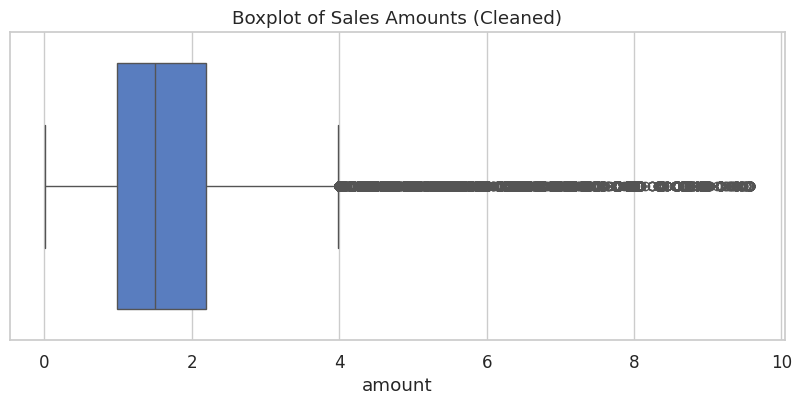

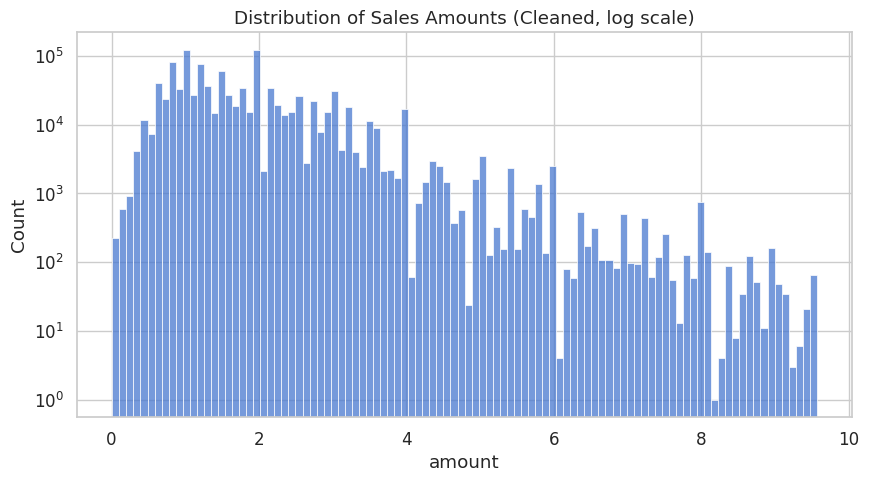

In [25]:
# Boxplot
plt.figure(figsize=(10,4))
sns.boxplot(x=merged['amount'])
plt.title("Boxplot of Sales Amounts (Cleaned)")
plt.show()

# Histogram (log scale for clarity)
plt.figure(figsize=(10,5))
sns.histplot(merged['amount'], bins=100)
plt.yscale('log')
plt.title("Distribution of Sales Amounts (Cleaned, log scale)")
plt.show()

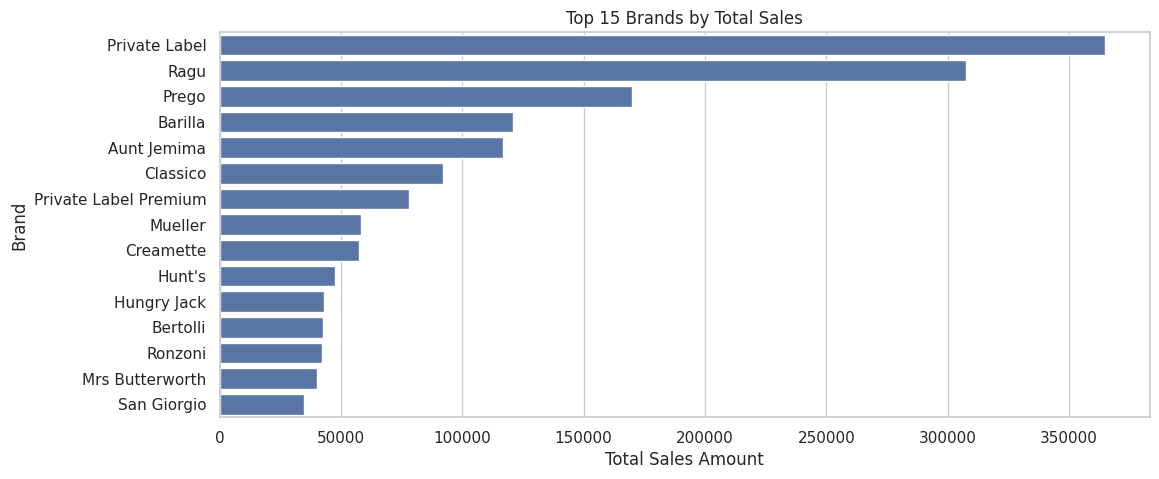

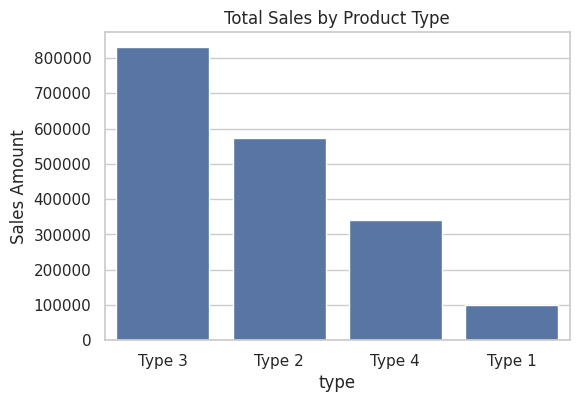

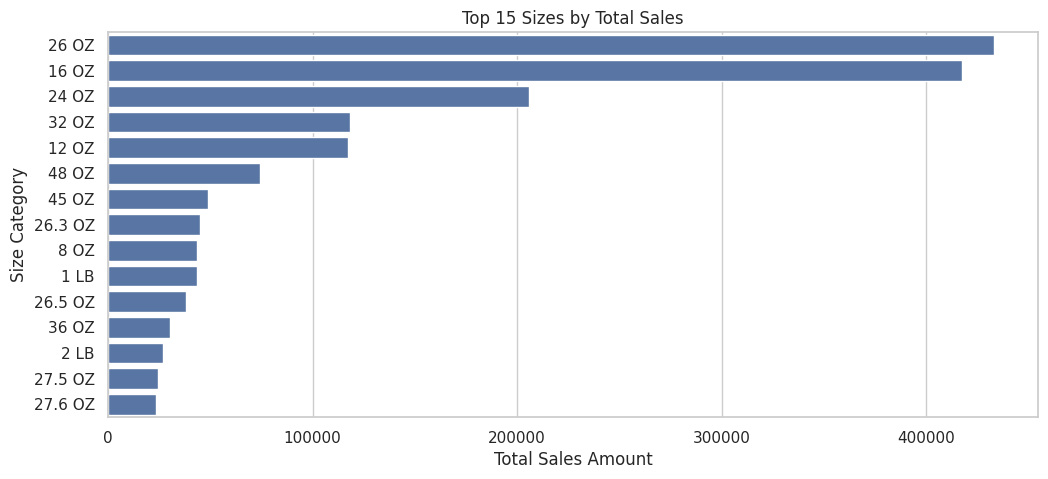

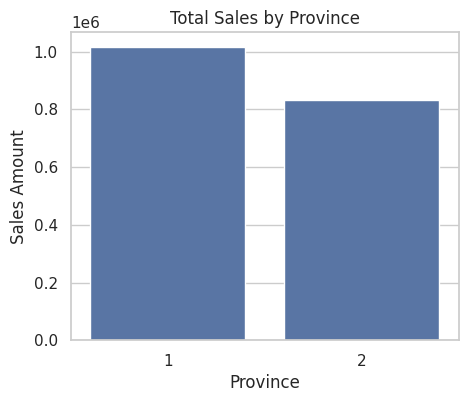

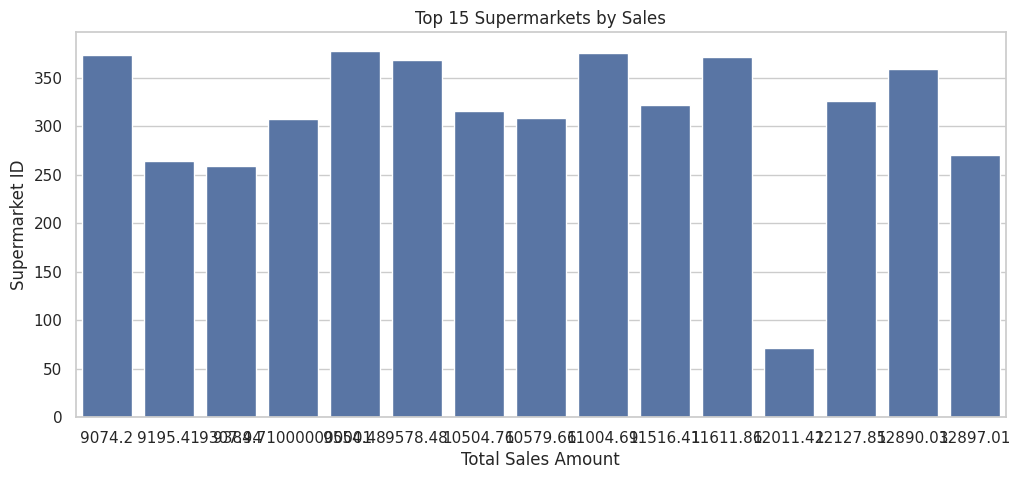

In [26]:

# set style
sns.set(style="whitegrid")

# 1. Sales by Brand (top 15)
plt.figure(figsize=(12,5))
top_brands = merged.groupby('brand')['amount'].sum().sort_values(ascending=False).head(15)
sns.barplot(x=top_brands.values, y=top_brands.index)
plt.title("Top 15 Brands by Total Sales")
plt.xlabel("Total Sales Amount")
plt.ylabel("Brand")
plt.show()

# 2. Sales by Type
plt.figure(figsize=(6,4))
type_sales = merged.groupby('type')['amount'].sum().sort_values(ascending=False)
sns.barplot(x=type_sales.index, y=type_sales.values)
plt.title("Total Sales by Product Type")
plt.ylabel("Sales Amount")
plt.show()

# 3. Sales by Size Category (top 15)
plt.figure(figsize=(12,5))
top_sizes = merged.groupby('size_category')['amount'].sum().sort_values(ascending=False).head(15)
sns.barplot(x=top_sizes.values, y=top_sizes.index)
plt.title("Top 15 Sizes by Total Sales")
plt.xlabel("Total Sales Amount")
plt.ylabel("Size Category")
plt.show()

# 4. Sales by Province
plt.figure(figsize=(5,4))
prov_sales = merged.groupby('province')['amount'].sum()
sns.barplot(x=prov_sales.index, y=prov_sales.values)
plt.title("Total Sales by Province")
plt.xlabel("Province")
plt.ylabel("Sales Amount")
plt.show()

# 5. Sales by Supermarket (top 15)
plt.figure(figsize=(12,5))
top_stores = merged.groupby('supermarket')['amount'].sum().sort_values(ascending=False).head(15)
sns.barplot(x=top_stores.values, y=top_stores.index)
plt.title("Top 15 Supermarkets by Sales")
plt.xlabel("Total Sales Amount")
plt.ylabel("Supermarket ID")
plt.show()


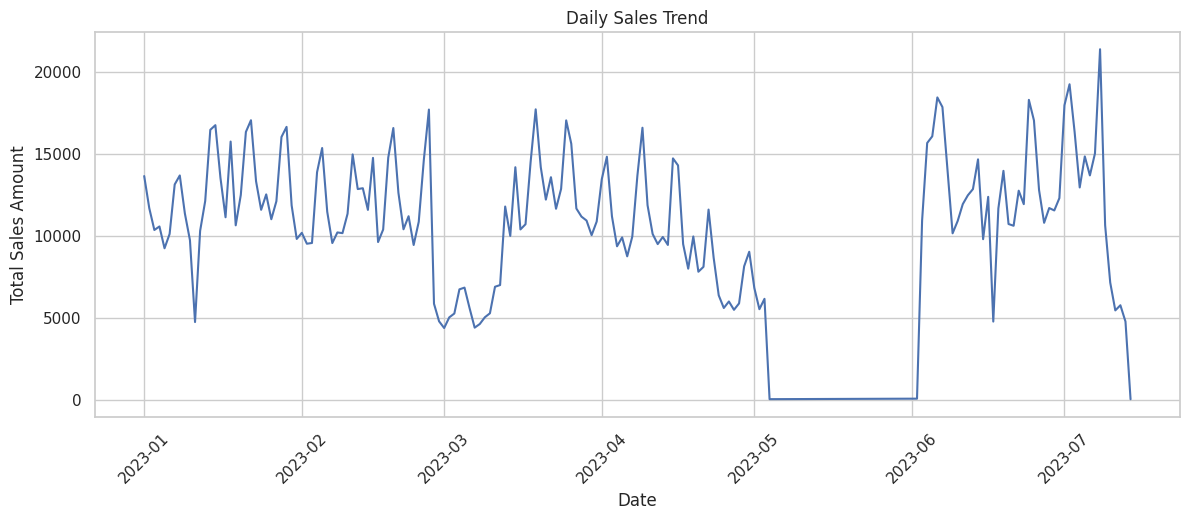

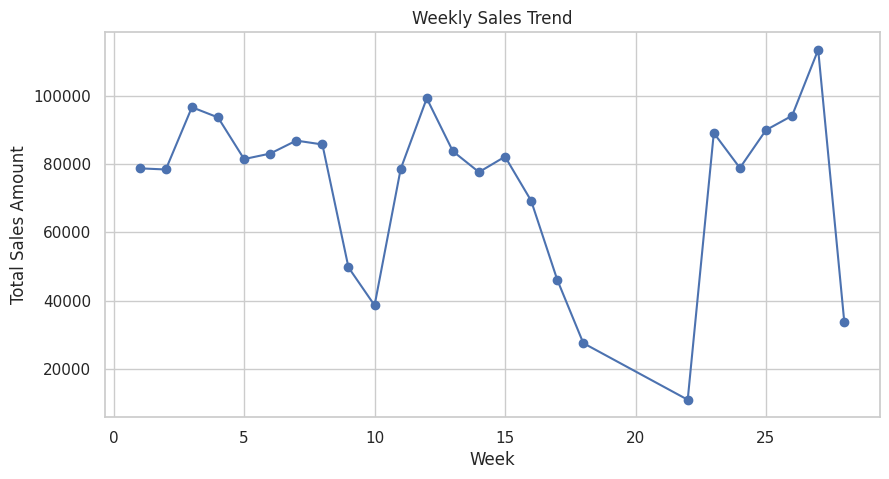

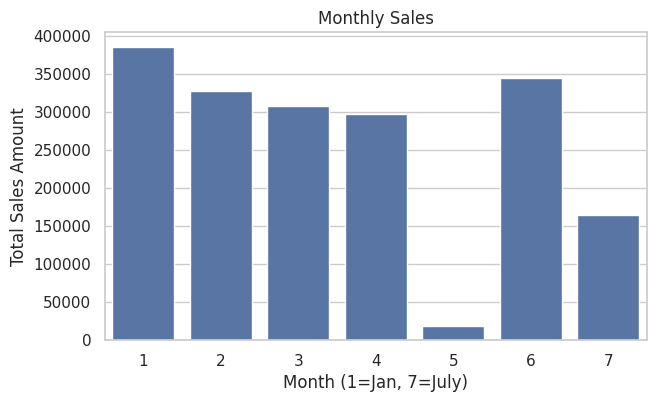

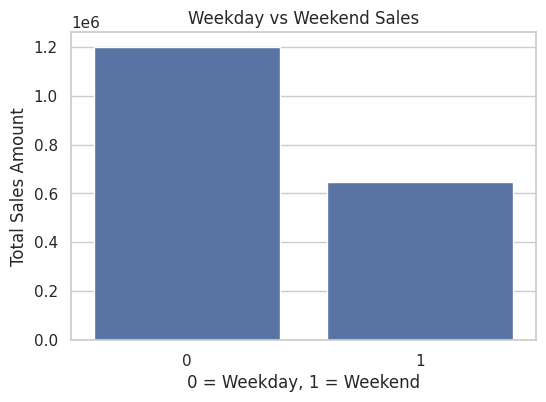

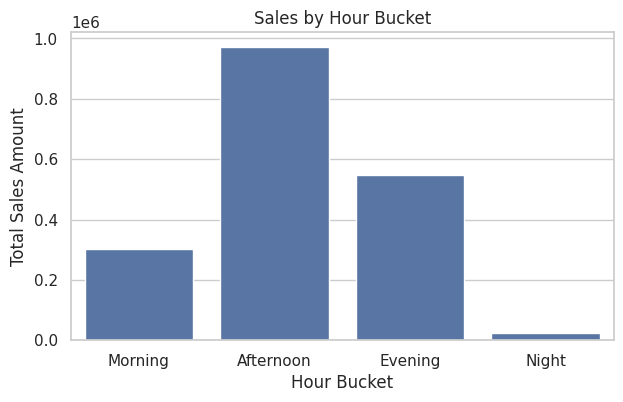

In [27]:
# 1. Daily Sales Trend
daily_sales = merged.groupby('date')['amount'].sum().reset_index()

plt.figure(figsize=(14,5))
plt.plot(daily_sales['date'], daily_sales['amount'])
plt.title("Daily Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales Amount")
plt.xticks(rotation=45)
plt.show()

# 2. Weekly Sales Trend
weekly_sales = merged.groupby('week')['amount'].sum().reset_index()

plt.figure(figsize=(10,5))
plt.plot(weekly_sales['week'], weekly_sales['amount'], marker='o')
plt.title("Weekly Sales Trend")
plt.xlabel("Week")
plt.ylabel("Total Sales Amount")
plt.show()

# 3. Monthly Sales
monthly_sales = merged.groupby('month')['amount'].sum().reset_index()

plt.figure(figsize=(7,4))
sns.barplot(x='month', y='amount', data=monthly_sales)
plt.title("Monthly Sales")
plt.xlabel("Month (1=Jan, 7=July)")
plt.ylabel("Total Sales Amount")
plt.show()

# 4. Weekday vs Weekend
weekend_sales = merged.groupby('is_weekend')['amount'].sum().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='is_weekend', y='amount', data=weekend_sales)
plt.title("Weekday vs Weekend Sales")
plt.xlabel("0 = Weekday, 1 = Weekend")
plt.ylabel("Total Sales Amount")
plt.show()

# 5. Hour Bucket
hour_sales = merged.groupby('hour_bucket')['amount'].sum().reset_index()

plt.figure(figsize=(7,4))
sns.barplot(x='hour_bucket', y='amount', data=hour_sales,
            order=["Morning","Afternoon","Evening","Night"])
plt.title("Sales by Hour Bucket")
plt.xlabel("Hour Bucket")
plt.ylabel("Total Sales Amount")
plt.show()


Average basket value: 2.7794397005075306
Median basket value: 2.19
Average basket size: 1.8615358919997411
Median basket size: 1.0


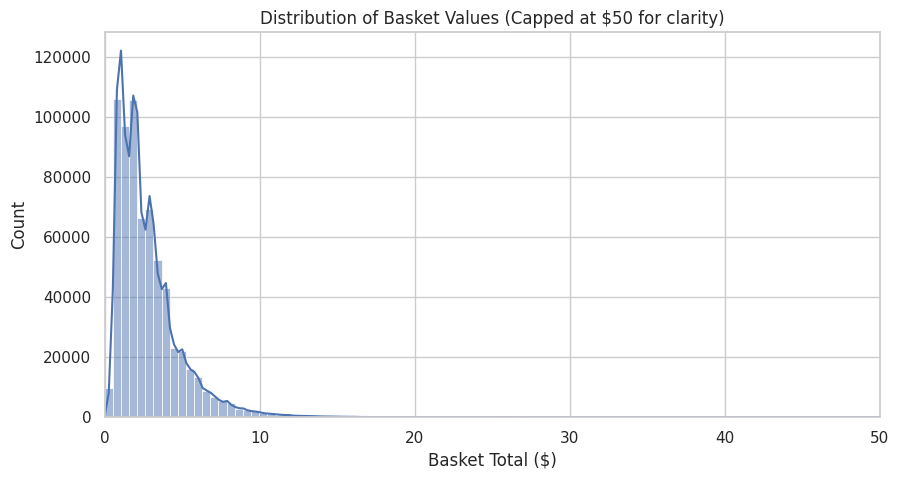

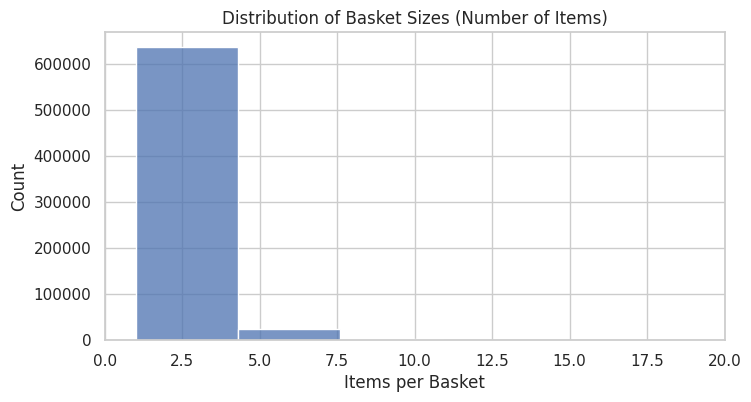

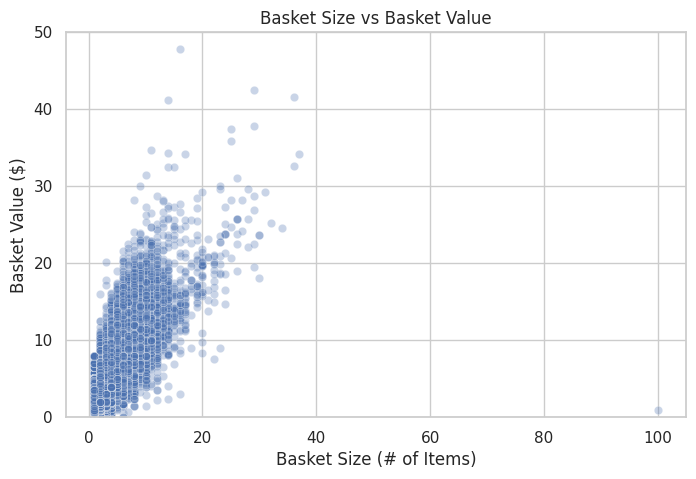

In [28]:
# 1. Basket value (sum of amount per basket)
basket_value = merged.groupby('basket')['amount'].sum().reset_index(name='basket_total')

# 2. Basket size (number of items per basket)
basket_size = merged.groupby('basket')['units'].sum().reset_index(name='basket_size')

# merge for combined analysis
basket_summary = pd.merge(basket_value, basket_size, on='basket')

print("Average basket value:", basket_summary['basket_total'].mean())
print("Median basket value:", basket_summary['basket_total'].median())
print("Average basket size:", basket_summary['basket_size'].mean())
print("Median basket size:", basket_summary['basket_size'].median())

# --- Plots ---


# 3. Distribution of basket values
plt.figure(figsize=(10,5))
sns.histplot(basket_summary['basket_total'], bins=100, kde=True)
plt.xlim(0, 50)  # focusing on normal range
plt.title("Distribution of Basket Values (Capped at $50 for clarity)")
plt.xlabel("Basket Total ($)")
plt.ylabel("Count")
plt.show()

# 4. Distribution of basket sizes
plt.figure(figsize=(8,4))
sns.histplot(basket_summary['basket_size'], bins=30, kde=False)
plt.xlim(0, 20)
plt.title("Distribution of Basket Sizes (Number of Items)")
plt.xlabel("Items per Basket")
plt.ylabel("Count")
plt.show()

# 5. Relationship: Basket Size vs Basket Value
plt.figure(figsize=(8,5))
sns.scatterplot(x='basket_size', y='basket_total', data=basket_summary, alpha=0.3)
plt.title("Basket Size vs Basket Value")
plt.xlabel("Basket Size (# of Items)")
plt.ylabel("Basket Value ($)")
plt.ylim(0, 50)
plt.show()


Unique customers: 249451
Average total spend per customer: 7.405023872423843
Median total spend per customer: 4.57
Average baskets per customer: 2.6642146152951884
Median baskets per customer: 2.0


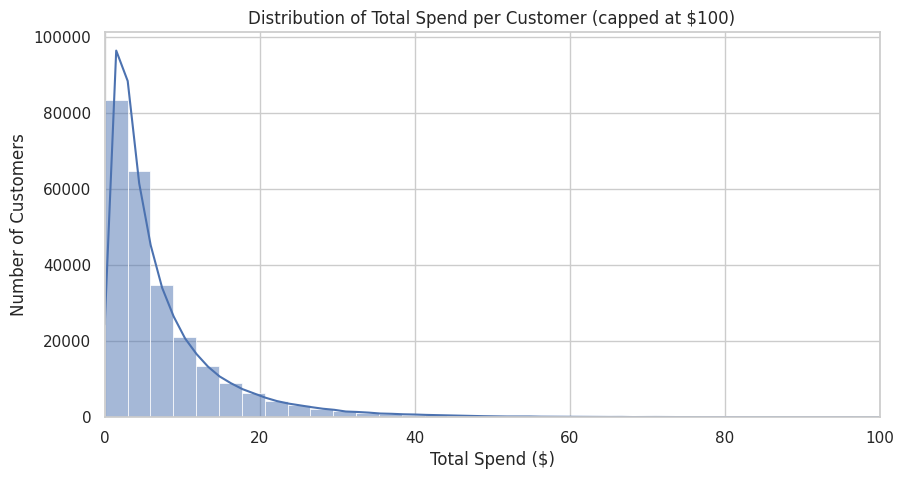

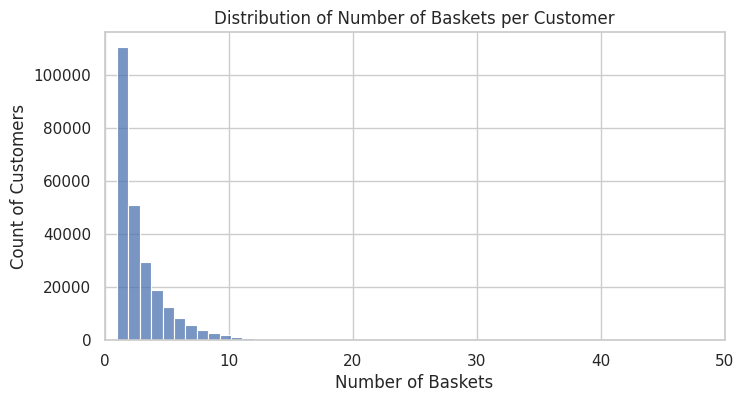

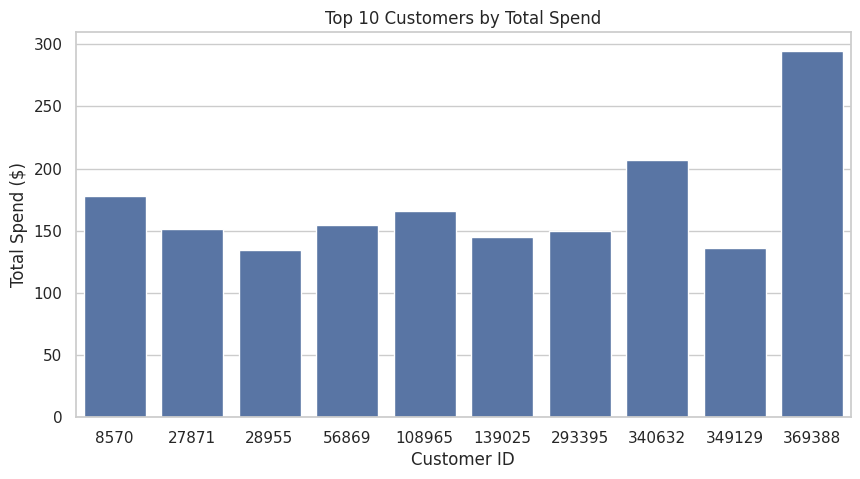

In [29]:
# 1. Number of unique customers
num_customers = merged['customer_id'].nunique()
print("Unique customers:", num_customers)

# 2. Total & average spend per customer
customer_sales = merged.groupby('customer_id')['amount'].sum().reset_index(name='total_spend')
customer_sales['avg_spend'] = merged.groupby('customer_id')['amount'].mean().values

# 3. Frequency: baskets per customer
customer_freq = merged.groupby('customer_id')['basket'].nunique().reset_index(name='num_baskets')

# merge both
customer_summary = pd.merge(customer_sales, customer_freq, on='customer_id')

print("Average total spend per customer:", customer_summary['total_spend'].mean())
print("Median total spend per customer:", customer_summary['total_spend'].median())
print("Average baskets per customer:", customer_summary['num_baskets'].mean())
print("Median baskets per customer:", customer_summary['num_baskets'].median())

# --- Plots ---


# 4. Distribution of total spend per customer
plt.figure(figsize=(10,5))
sns.histplot(customer_summary['total_spend'], bins=100, kde=True)
plt.xlim(0, 100)  # focus on normal range
plt.title("Distribution of Total Spend per Customer (capped at $100)")
plt.xlabel("Total Spend ($)")
plt.ylabel("Number of Customers")
plt.show()

# 5. Distribution of number of baskets (frequency)
plt.figure(figsize=(8,4))
sns.histplot(customer_summary['num_baskets'], bins=50, kde=False)
plt.xlim(0, 50)
plt.title("Distribution of Number of Baskets per Customer")
plt.xlabel("Number of Baskets")
plt.ylabel("Count of Customers")
plt.show()

# 6. Top 10 customers by total spend
top_customers = customer_summary.sort_values('total_spend', ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x='customer_id', y='total_spend', data=top_customers)
plt.title("Top 10 Customers by Total Spend")
plt.xlabel("Customer ID")
plt.ylabel("Total Spend ($)")
plt.show()


In [30]:

# setting reference date
reference_date = merged['date'].max()

# grouping by customer
rfm = merged.groupby('customer_id').agg({
    'date': lambda x: (reference_date - x.max()).days,   # recency
    'basket': 'nunique',                                # frequency
    'amount': 'sum'                                     # monetary
}).reset_index()

# renaming columns
rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

# checking head
print(rfm.head())


   customer_id  recency  frequency  monetary
0            1      160          1      3.29
1            2       11         14     61.59
2            5      124          2      6.33
3            6       13          1      0.79
4            7      170          1      1.69


In [31]:
# scoring each dimension
rfm['R_score'] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_score'] = pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5]).astype(int)

# overall RFM score
rfm['RFM_score'] = rfm['R_score']*100 + rfm['F_score']*10 + rfm['M_score']

# segmenting (example simple rules)
rfm['segment'] = 'Others'
rfm.loc[rfm['RFM_score'] >= 555, 'segment'] = 'Champions'
rfm.loc[(rfm['R_score']>=4) & (rfm['F_score']>=4), 'segment'] = 'Loyal Customers'
rfm.loc[(rfm['R_score']>=4) & (rfm['F_score']<=2), 'segment'] = 'Recent Customers'
rfm.loc[(rfm['R_score']<=2) & (rfm['F_score']>=4), 'segment'] = 'At Risk'

print(rfm['segment'].value_counts())


segment
Others              149993
Loyal Customers      62028
Recent Customers     20016
At Risk              17414
Name: count, dtype: int64


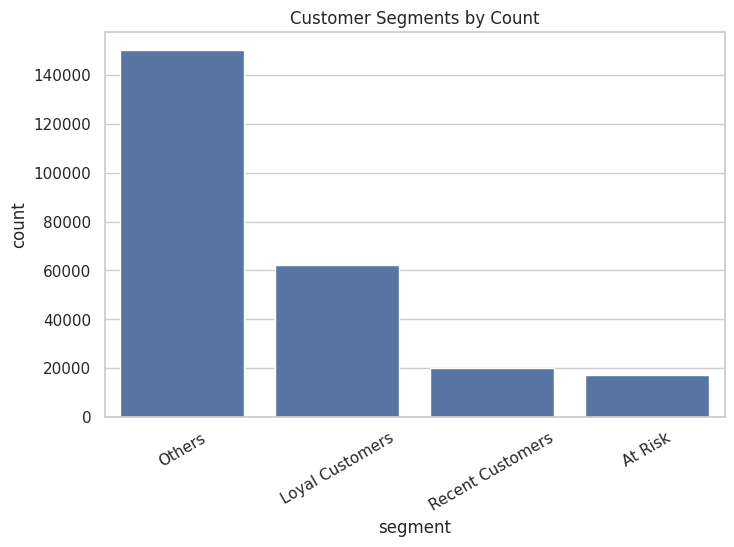

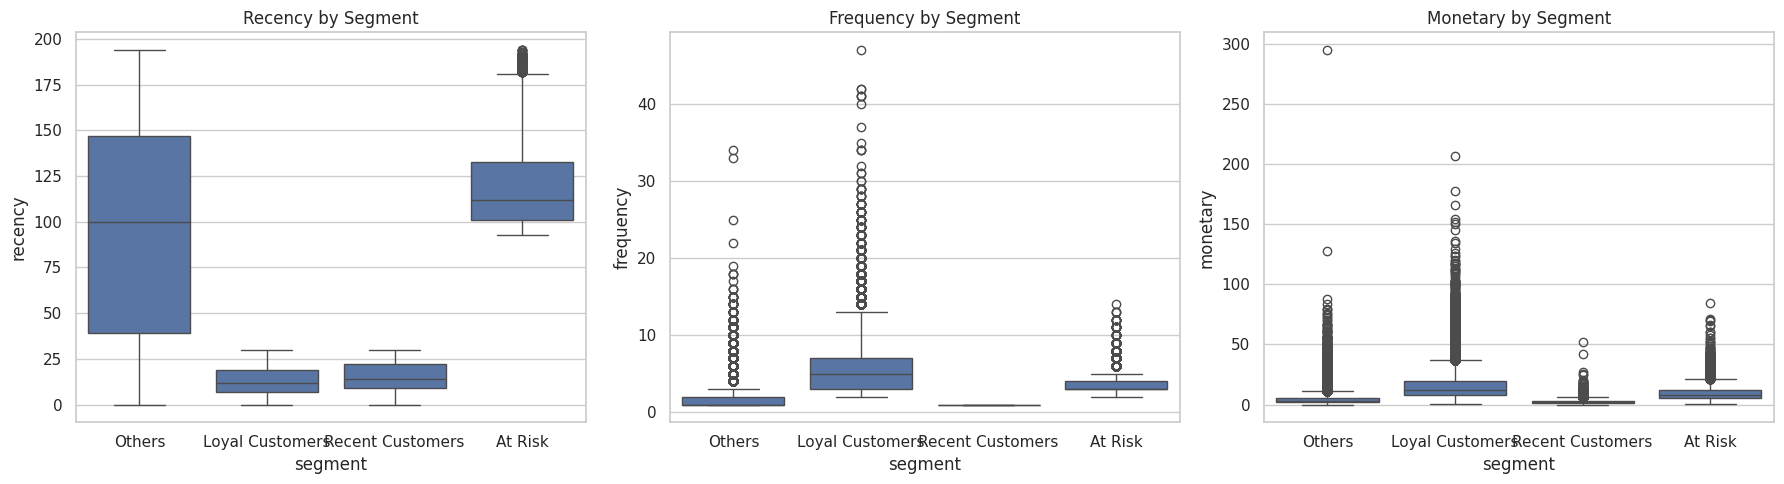

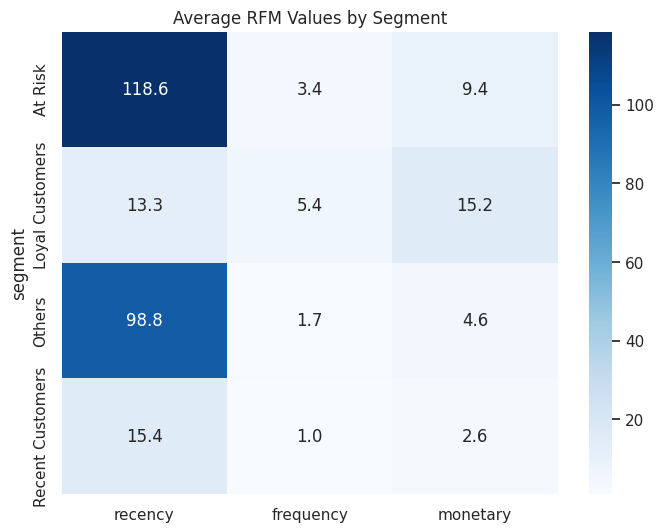

In [32]:

# barplot of segment counts
plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='segment', order=rfm['segment'].value_counts().index)
plt.title("Customer Segments by Count")
plt.xticks(rotation=30)
plt.show()

# boxplots of R, F, M by segment
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.boxplot(data=rfm, x='segment', y='recency', ax=axes[0])
axes[0].set_title("Recency by Segment")
sns.boxplot(data=rfm, x='segment', y='frequency', ax=axes[1])
axes[1].set_title("Frequency by Segment")
sns.boxplot(data=rfm, x='segment', y='monetary', ax=axes[2])
axes[2].set_title("Monetary by Segment")
plt.tight_layout()
plt.show()

# heatmap of mean RFM values per segment
rfm_summary = rfm.groupby('segment')[['recency','frequency','monetary']].mean().round(1)
plt.figure(figsize=(8,6))
sns.heatmap(rfm_summary, annot=True, fmt=".1f", cmap="Blues")
plt.title("Average RFM Values by Segment")
plt.show()


In [33]:
# grouping transactions to customer-day level (one row per customer per date)
daily = (merged
         .groupby(['customer_id','date'])
         .agg(amount_sum=('amount','sum'),
              items_sum=('units','sum'),
              baskets_n=('basket','nunique'))
         .reset_index())

# sorting by customer and date
daily = daily.sort_values(['customer_id','date'])

# creating previous and next purchase dates per customer
daily['prev_date'] = daily.groupby('customer_id')['date'].shift(1)
daily['next_date'] = daily.groupby('customer_id')['date'].shift(-1)

# creating recency (days since previous purchase) at each visit
daily['recency_days'] = (daily['date'] - daily['prev_date']).dt.days
daily['recency_days'] = daily['recency_days'].fillna(999).astype(int)  # using big number for first visit

# creating days to next purchase and the churn label (return within 30 days)
daily['days_to_next'] = (daily['next_date'] - daily['date']).dt.days
daily['will_return_30d'] = (daily['days_to_next'] <= 30).astype('Int64').fillna(0).astype(int)

# keeping only rows where we can evaluate a future return (dropping last visits with no future info)
snapshot = daily.dropna(subset=['next_date']).copy()

# checking label balance
pos_rate = snapshot['will_return_30d'].mean()
print("snapshot shape:", snapshot.shape)
print("positive rate (return within 30d):", round(pos_rate, 4))

# quick preview
snapshot.head(50)


snapshot shape: (409725, 10)
positive rate (return within 30d): 0.6128


,customer_id,date,amount_sum,items_sum,baskets_n,prev_date,next_date,recency_days,days_to_next,will_return_30d
1,2,2023-01-26,6.88,2,1,NaT,2023-01-29,999,3.0,1
2,2,2023-01-29,4.14,2,1,2023-01-26,2023-02-03,3,5.0,1
3,2,2023-02-03,5.70,2,1,2023-01-29,2023-02-12,5,9.0,1
4,2,2023-02-12,2.29,1,1,2023-02-03,2023-02-16,9,4.0,1
5,2,2023-02-16,2.49,1,1,2023-02-12,2023-03-05,4,17.0,1
6,2,2023-03-05,4.55,3,1,2023-02-16,2023-03-20,17,15.0,1
7,2,2023-03-20,4.31,2,1,2023-03-05,2023-04-02,15,13.0,1
8,2,2023-04-02,1.04,1,1,2023-03-20,2023-06-06,13,65.0,0
9,2,2023-06-06,3.59,1,1,2023-04-02,2023-06-15,65,9.0,1
10,2,2023-06-15,4.48,2,1,2023-06-06,2023-06-17,9,2.0,1


In [34]:
# making rolling features (using expanding window per customer)
snapshot = snapshot.sort_values(['customer_id','date'])

# 7-day and 30-day rolling spend
snapshot['rolling_7d_amount'] = (snapshot.groupby('customer_id')['amount_sum']
                                 .rolling(window=7, min_periods=1).mean().reset_index(0,drop=True))

snapshot['rolling_30d_amount'] = (snapshot.groupby('customer_id')['amount_sum']
                                  .rolling(window=30, min_periods=1).mean().reset_index(0,drop=True))

# rolling frequency (visits per 30 days)
snapshot['rolling_30d_freq'] = (snapshot.groupby('customer_id')['date']
                                .rolling(window=30, min_periods=1).count().reset_index(0,drop=True))

# filling any NaNs with 0
snapshot = snapshot.fillna(0)

# quick check of engineered features
snapshot[['customer_id','date','recency_days','amount_sum','items_sum','rolling_7d_amount','rolling_30d_amount','rolling_30d_freq','will_return_30d']].head(10)


,customer_id,date,recency_days,amount_sum,items_sum,rolling_7d_amount,rolling_30d_amount,rolling_30d_freq,will_return_30d
1,2,2023-01-26,999,6.88,2,6.880000,6.880000,1.0,1
2,2,2023-01-29,3,4.14,2,5.510000,5.510000,2.0,1
3,2,2023-02-03,5,5.70,2,5.573333,5.573333,3.0,1
4,2,2023-02-12,9,2.29,1,4.752500,4.752500,4.0,1
5,2,2023-02-16,4,2.49,1,4.300000,4.300000,5.0,1
6,2,2023-03-05,17,4.55,3,4.341667,4.341667,6.0,1
7,2,2023-03-20,15,4.31,2,4.337143,4.337143,7.0,1
8,2,2023-04-02,13,1.04,1,3.502857,3.925000,8.0,0
9,2,2023-06-06,65,3.59,1,3.424286,3.887778,9.0,1
10,2,2023-06-15,9,4.48,2,3.250000,3.947000,10.0,1


In [35]:

# defining feature list again
feat_cols = ['recency_days','amount_sum','items_sum',
             'rolling_7d_amount','rolling_30d_amount','rolling_30d_freq']

# checking missing values
print("=== Missing values per column ===")
print(snapshot[feat_cols].isna().sum())

# checking basic stats
print("\n=== Summary stats for features ===")
print(snapshot[feat_cols].describe())

# checking if any inf or -inf
print("\nAny infinite values?", np.isinf(snapshot[feat_cols]).any().any())


=== Missing values per column ===
recency_days          0
amount_sum            0
items_sum             0
rolling_7d_amount     0
rolling_30d_amount    0
rolling_30d_freq      0
dtype: int64

=== Summary stats for features ===
        recency_days     amount_sum      items_sum  rolling_7d_amount  rolling_30d_amount  rolling_30d_freq
count  409725.000000  409725.000000  409725.000000      409725.000000       409725.000000     409725.000000
mean      355.030952       2.828682       1.874111           2.850597            2.851866          3.128332
std       459.923542       2.093916       1.328533           1.664842            1.661739          2.731481
min         1.000000       0.010000       1.000000           0.010000            0.010000          1.000000
25%        13.000000       1.340000       1.000000           1.750000            1.756667          1.000000
50%        38.000000       2.250000       1.000000           2.507500            2.515000          2.000000
75%       999.000

In [36]:

# using same feature list
X = snapshot[feat_cols]
y = snapshot['will_return_30d']

# splitting train/test by time (avoid leakage)
cutoff = snapshot['date'].quantile(0.8)
train = snapshot[snapshot['date'] <= cutoff]
valid = snapshot[snapshot['date'] > cutoff]

X_tr, y_tr = train[feat_cols], train['will_return_30d']
X_va, y_va = valid[feat_cols], valid['will_return_30d']

# logistic regression
logit = LogisticRegression(max_iter=1000)
logit.fit(X_tr, y_tr)

# predictions
pred_prob = logit.predict_proba(X_va)[:,1]

# evaluation
auc = roc_auc_score(y_va, pred_prob)
ap  = average_precision_score(y_va, pred_prob)

print("Logistic Regression AUC:", round(auc,4))
print("Logistic Regression PR-AUC:", round(ap,4))
print("\nClassification Report:\n", classification_report(y_va, (pred_prob>0.5).astype(int)))


Logistic Regression AUC: 0.5994
Logistic Regression PR-AUC: 0.8288

Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.07      0.11     19420
           1       0.76      0.95      0.84     60837

    accuracy                           0.73     80257
   macro avg       0.53      0.51      0.48     80257
weighted avg       0.65      0.73      0.67     80257



In [37]:
# training logistic regression with class weighting (same train/valid split as above)

# training
logit_bal = LogisticRegression(max_iter=1000, class_weight="balanced")
logit_bal.fit(X_tr, y_tr)

# predicting
pred_prob_bal = logit_bal.predict_proba(X_va)[:, 1]

# evaluating
auc_bal = roc_auc_score(y_va, pred_prob_bal)
ap_bal  = average_precision_score(y_va, pred_prob_bal)

print("Logistic Regression (class_weight='balanced') AUC:", round(auc_bal, 4))
print("Logistic Regression (class_weight='balanced') PR-AUC:", round(ap_bal, 4))
print("\nClassification Report:\n", classification_report(y_va, (pred_prob_bal > 0.5).astype(int)))


Logistic Regression (class_weight='balanced') AUC: 0.5993
Logistic Regression (class_weight='balanced') PR-AUC: 0.8287

Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.21      0.24     19420
           1       0.77      0.84      0.80     60837

    accuracy                           0.69     80257
   macro avg       0.53      0.52      0.52     80257
weighted avg       0.65      0.69      0.67     80257



In [38]:

# define custom weights
# give more penalty for misclassifying class 0 (non-returners)
weights = {0: 3.0, 1: 1.0}   # try 3x, you can tune to 2x, 5x etc.

logit_wt = LogisticRegression(max_iter=1000, class_weight=weights)
logit_wt.fit(X_tr, y_tr)

# predict
prob_wt = logit_wt.predict_proba(X_va)[:,1]

print("AUC (weighted):", round(roc_auc_score(y_va, prob_wt), 4))
print("PR-AUC (weighted):", round(average_precision_score(y_va, prob_wt), 4))
print("\nClassification Report:\n", classification_report(y_va, (prob_wt>0.5).astype(int)))


AUC (weighted): 0.5991
PR-AUC (weighted): 0.8286

Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.91      0.41     19420
           1       0.88      0.20      0.33     60837

    accuracy                           0.37     80257
   macro avg       0.57      0.56      0.37     80257
weighted avg       0.73      0.37      0.35     80257



In [39]:

# training Gradient Boosting
gbm = GradientBoostingClassifier(random_state=42)
gbm.fit(X_tr, y_tr)

# predictions
gbm_pred = gbm.predict_proba(X_va)[:,1]

# evaluation
gbm_auc = roc_auc_score(y_va, gbm_pred)
gbm_ap  = average_precision_score(y_va, gbm_pred)

print("Gradient Boosting AUC:", round(gbm_auc,4))
print("Gradient Boosting PR-AUC:", round(gbm_ap,4))
print("\nClassification Report:\n", classification_report(y_va, (gbm_pred>0.5).astype(int)))


Gradient Boosting AUC: 0.462
Gradient Boosting PR-AUC: 0.7631

Classification Report:
               precision    recall  f1-score   support

           0       0.18      0.17      0.17     19420
           1       0.74      0.75      0.74     60837

    accuracy                           0.61     80257
   macro avg       0.46      0.46      0.46     80257
weighted avg       0.60      0.61      0.61     80257



In [40]:
# making first purchase date per customer
first_purchase = snapshot.groupby('customer_id')['date'].transform('min')
snapshot['tenure_days'] = (snapshot['date'] - first_purchase).dt.days

# adding time-based features
snapshot['day_of_week'] = snapshot['date'].dt.dayofweek
snapshot['is_weekend'] = snapshot['day_of_week'].isin([5,6]).astype(int)

# avg basket value & size so far per customer
snapshot['avg_basket_value'] = snapshot.groupby('customer_id')['amount_sum'].expanding().mean().reset_index(level=0, drop=True)
snapshot['avg_basket_size'] = snapshot.groupby('customer_id')['items_sum'].expanding().mean().reset_index(level=0, drop=True)

# fill any NaNs (from first rows) with 0
snapshot = snapshot.fillna(0)

# new feature list
feat_cols = [
    'recency_days','amount_sum','items_sum',
    'rolling_7d_amount','rolling_30d_amount','rolling_30d_freq',
    'tenure_days','day_of_week','is_weekend',
    'avg_basket_value','avg_basket_size'
]

# checking
snapshot[feat_cols + ['will_return_30d']].head(10)


,recency_days,amount_sum,items_sum,rolling_7d_amount,rolling_30d_amount,rolling_30d_freq,tenure_days,day_of_week,is_weekend,avg_basket_value,avg_basket_size,will_return_30d
1,999,6.88,2,6.880000,6.880000,1.0,0,3,0,6.880000,2.000000,1
2,3,4.14,2,5.510000,5.510000,2.0,3,6,1,5.510000,2.000000,1
3,5,5.70,2,5.573333,5.573333,3.0,8,4,0,5.573333,2.000000,1
4,9,2.29,1,4.752500,4.752500,4.0,17,6,1,4.752500,1.750000,1
5,4,2.49,1,4.300000,4.300000,5.0,21,3,0,4.300000,1.600000,1
6,17,4.55,3,4.341667,4.341667,6.0,38,6,1,4.341667,1.833333,1
7,15,4.31,2,4.337143,4.337143,7.0,53,0,0,4.337143,1.857143,1
8,13,1.04,1,3.502857,3.925000,8.0,66,6,1,3.925000,1.750000,0
9,65,3.59,1,3.424286,3.887778,9.0,131,1,0,3.887778,1.666667,1
10,9,4.48,2,3.250000,3.947000,10.0,140,3,0,3.947000,1.700000,1


In [41]:

# train/test split again by time
cutoff = snapshot['date'].quantile(0.8)
train = snapshot[snapshot['date'] <= cutoff]
valid = snapshot[snapshot['date'] > cutoff]

X_tr, y_tr = train[feat_cols], train['will_return_30d']
X_va, y_va = valid[feat_cols], valid['will_return_30d']

# gradient boosting with tuned params
gbm = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
gbm.fit(X_tr, y_tr)

# predictions
gbm_pred = gbm.predict_proba(X_va)[:,1]

# evaluation
gbm_auc = roc_auc_score(y_va, gbm_pred)
gbm_ap  = average_precision_score(y_va, gbm_pred)

print("Tuned Gradient Boosting AUC:", round(gbm_auc,4))
print("Tuned Gradient Boosting PR-AUC:", round(gbm_ap,4))
print("\nClassification Report:\n", classification_report(y_va, (gbm_pred>0.5).astype(int)))


Tuned Gradient Boosting AUC: 0.3529
Tuned Gradient Boosting PR-AUC: 0.674

Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.60      0.29     19420
           1       0.62      0.21      0.31     60837

    accuracy                           0.30     80257
   macro avg       0.41      0.40      0.30     80257
weighted avg       0.52      0.30      0.31     80257



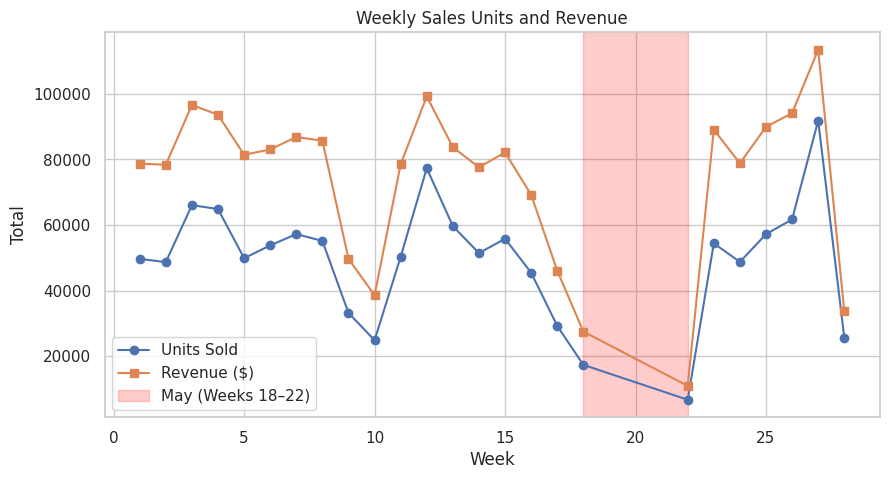

,week,units,revenue
14,15,55840,82150.29
15,16,45498,69246.21
16,17,29284,46122.96
17,18,17414,27555.93
18,22,6774,10991.22
19,23,54446,89074.07
20,24,48782,78843.55
21,25,57225,89929.31


In [42]:

# weekly sales volume (units + revenue)
weekly_check = (merged
                .groupby('week')
                .agg(units=('units','sum'),
                     revenue=('amount','sum'))
                .reset_index())

plt.figure(figsize=(10,5))
plt.plot(weekly_check['week'], weekly_check['units'], marker='o', label='Units Sold')
plt.plot(weekly_check['week'], weekly_check['revenue'], marker='s', label='Revenue ($)')
plt.axvspan(18, 22, color='red', alpha=0.2, label='May (Weeks 18–22)')
plt.xlabel("Week")
plt.ylabel("Total")
plt.title("Weekly Sales Units and Revenue")
plt.legend()
plt.grid(True)
plt.show()

weekly_check[(weekly_check['week']>=15) & (weekly_check['week']<=25)]


In [43]:
# filter May weeks
may_data = merged[(merged['week'] >= 18) & (merged['week'] <= 22)].copy()

# quick summary
print("May (weeks 18–22) summary")
print(may_data.groupby('week').agg(
    transactions=('basket','nunique'),
    customers=('customer_id','nunique'),
    units=('units','sum'),
    revenue=('amount','sum')
))

# check how many unique supermarkets reported sales each week
print("\nStores active per week:")
print(may_data.groupby('week')['supermarket'].nunique())


May (weeks 18–22) summary
      transactions  customers  units   revenue
week                                          
18            9848       9607  17414  27555.93
22            3936       3917   6774  10991.22

Stores active per week:
week
18    219
22    298
Name: supermarket, dtype: int64


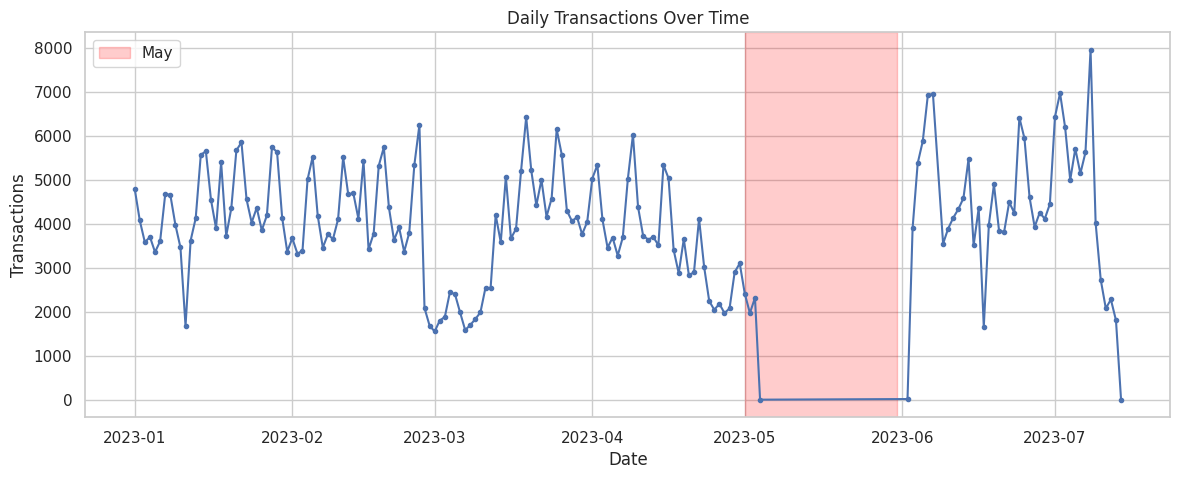

,date,transactions,customers,units,revenue
120,2023-05-01,2418,2404,4298,6819.77
121,2023-05-02,1980,1966,3525,5521.83
122,2023-05-03,2328,2319,3931,6154.79
123,2023-05-04,13,13,27,34.36


In [44]:
# count sales per day
day_check = (merged
             .groupby('date')
             .agg(transactions=('basket','nunique'),
                  customers=('customer_id','nunique'),
                  units=('units','sum'),
                  revenue=('amount','sum'))
             .reset_index())

# plot daily transactions to spot gaps
plt.figure(figsize=(14,5))
plt.plot(day_check['date'], day_check['transactions'], marker='.', linestyle='-')
plt.axvspan("2023-05-01","2023-05-31", color='red', alpha=0.2, label="May")
plt.title("Daily Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.legend()
plt.grid(True)
plt.show()

# print May 1–31
day_check[(day_check['date']>="2023-05-01") & (day_check['date']<="2023-05-31")]


In [45]:
# filtering out May (weeks 18–22 or May dates)
snapshot_clean = snapshot[~snapshot['date'].between("2023-05-01", "2023-05-31")]


print("Customer snapshot shape:", snapshot_clean.shape)


Customer snapshot shape: (405893, 18)


In [46]:

# define features and target
feat_cols = [
    'recency_days','amount_sum','items_sum',
    'rolling_7d_amount','rolling_30d_amount','rolling_30d_freq',
    'tenure_days','day_of_week','is_weekend',
    'avg_basket_value','avg_basket_size'
]
X = snapshot_clean[feat_cols]
y = snapshot_clean['will_return_30d']

# train/test split by date (temporal split is better)
cutoff_date = "2023-06-01"
X_train = snapshot_clean[snapshot_clean['date'] < cutoff_date][feat_cols]
y_train = snapshot_clean[snapshot_clean['date'] < cutoff_date]['will_return_30d']
X_test  = snapshot_clean[snapshot_clean['date'] >= cutoff_date][feat_cols]
y_test  = snapshot_clean[snapshot_clean['date'] >= cutoff_date]['will_return_30d']

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
pred_lr = lr.predict_proba(X_test)[:,1]

print("Logistic Regression AUC:", roc_auc_score(y_test, pred_lr))
print("Logistic Regression PR-AUC:", average_precision_score(y_test, pred_lr))
print(classification_report(y_test, (pred_lr > 0.5).astype(int)))

# Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict_proba(X_test)[:,1]

print("RandomForest AUC:", roc_auc_score(y_test, pred_rf))
print("RandomForest PR-AUC:", average_precision_score(y_test, pred_rf))
print(classification_report(y_test, (pred_rf > 0.5).astype(int)))


Logistic Regression AUC: 0.5171022979398379
Logistic Regression PR-AUC: 0.9761405442692388
              precision    recall  f1-score   support

           0       0.03      0.83      0.06      1668
           1       0.98      0.21      0.35     57166

    accuracy                           0.23     58834
   macro avg       0.50      0.52      0.20     58834
weighted avg       0.95      0.23      0.34     58834

RandomForest AUC: 0.49292357563412237
RandomForest PR-AUC: 0.9698555111125604
              precision    recall  f1-score   support

           0       0.03      0.82      0.05      1668
           1       0.96      0.12      0.22     57166

    accuracy                           0.14     58834
   macro avg       0.49      0.47      0.14     58834
weighted avg       0.93      0.14      0.22     58834



In [47]:
# checking distribution of the target in the cleaned snapshot
print("Class distribution (will_return_30d):")
print(snapshot_clean['will_return_30d'].value_counts())

print("\nClass distribution normalized (%):")
print(snapshot_clean['will_return_30d'].value_counts(normalize=True))


Class distribution (will_return_30d):
will_return_30d
1    250987
0    154906
Name: count, dtype: int64

Class distribution normalized (%):
will_return_30d
1    0.618358
0    0.381642
Name: proportion, dtype: float64


In [48]:

# features
feat_cols = [
    'recency_days','amount_sum','items_sum',
    'rolling_7d_amount','rolling_30d_amount','rolling_30d_freq',
    'tenure_days','day_of_week','is_weekend',
    'avg_basket_value','avg_basket_size'
]

X = snapshot_clean[feat_cols]
y = snapshot_clean['will_return_30d']

# random split instead of cutoff date
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression with class weights
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(X_train, y_train)
pred_lr = lr.predict_proba(X_test)[:,1]

print("Logistic Regression AUC:", roc_auc_score(y_test, pred_lr))
print("Logistic Regression PR-AUC:", average_precision_score(y_test, pred_lr))
print(classification_report(y_test, (pred_lr > 0.5).astype(int)))

# Random Forest with class weights
rf = RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)
pred_rf = rf.predict_proba(X_test)[:,1]

print("RandomForest AUC:", roc_auc_score(y_test, pred_rf))
print("RandomForest PR-AUC:", average_precision_score(y_test, pred_rf))
print(classification_report(y_test, (pred_rf > 0.5).astype(int)))


Logistic Regression AUC: 0.6158472080656465
Logistic Regression PR-AUC: 0.7409983948439095
              precision    recall  f1-score   support

           0       0.45      0.67      0.54     30981
           1       0.71      0.49      0.58     50198

    accuracy                           0.56     81179
   macro avg       0.58      0.58      0.56     81179
weighted avg       0.61      0.56      0.56     81179

RandomForest AUC: 0.6698797306740708
RandomForest PR-AUC: 0.7940415455313475
              precision    recall  f1-score   support

           0       0.48      0.78      0.59     30981
           1       0.78      0.48      0.59     50198

    accuracy                           0.59     81179
   macro avg       0.63      0.63      0.59     81179
weighted avg       0.66      0.59      0.59     81179



In [49]:
# === Supervised ML: Predicting Basket Revenue  ===


# checking: defining promo-important SKUs from promotion table
promo_codes = set(promotion['code'].unique())

# checking: filtering invalid prices (dropping amount <= 0)
data = merged[merged['amount'] > 0].copy()

# checking: tagging promo-important items and private label
data['is_promo_item'] = data['code'].isin(promo_codes).astype(int)
data['is_private_label'] = data['brand'].str.contains('Private Label', case=False, na=False).astype(int)

# checking: computing extended line revenue = amount * units
data['line_revenue'] = data['amount'] * data['units']

# checking: building basket-level features (one store per basket expected)
basket_df = (
    data.groupby('basket')
        .agg(
            # target
            basket_revenue=('line_revenue','sum'),
            # volume/size
            items_sum=('units','sum'),
            n_products=('code','nunique'),
            # promo / private label composition
            promo_units=('is_promo_item','sum'),
            priv_units=('is_private_label','sum'),
            # customer incentives / timing
            voucher_used=('voucher','max'),
            is_weekend=('is_weekend','max'),
            hour=('hour','median'),
            # store / geo / calendar
            supermarket=('supermarket','first'),
            province=('province','first'),
            date=('date','max'),
            # diversity
            brand_diversity=('brand','nunique'),
            size_diversity=('size_category','nunique'),
            # price level proxy
            avg_unit_price=('amount','mean')
        )
        .reset_index()
)

# checking: deriving helpful ratios
basket_df['promo_share'] = basket_df['promo_units'] / basket_df['items_sum'].replace(0, np.nan)
basket_df['private_share'] = basket_df['priv_units'] / basket_df['items_sum'].replace(0, np.nan)
basket_df['month'] = basket_df['date'].dt.month

# checking: cleaning any residual inf/nan from divisions
basket_df = basket_df.replace([np.inf, -np.inf], np.nan).fillna(0)

# checking: selecting features and target
feat_cols = [
    'items_sum','n_products','voucher_used','is_weekend','hour',
    'brand_diversity','size_diversity','avg_unit_price',
    'promo_share','private_share',
    'supermarket','province','month'
]
target = 'basket_revenue'

X = basket_df[feat_cols].copy()
y = basket_df[target].copy()

# checking: encoding categorical-like integer ids as ordinal
enc_cols = ['supermarket','province','month']
X[enc_cols] = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1).fit_transform(X[enc_cols])

# checking: train/test split (random split for best pure-predictive metrics)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# checking: training 3 simple models
models = {
    'Linear': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=300, max_depth=14, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=400, learning_rate=0.05, max_depth=4, random_state=42)
}

for name, m in models.items():
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = (mean_squared_error(y_test, y_pred))**0.5
    r2 = r2_score(y_test, y_pred)
    print(f"{name} — MAE: {mae:.3f}  RMSE: {rmse:.3f}  R²: {r2:.3f}")

# checking: showing top feature importances for GradientBoosting
gbr = models['GradientBoosting']
importances = pd.Series(gbr.feature_importances_, index=feat_cols).sort_values(ascending=False)
print("\nTop importances (GradientBoosting):")
print(importances.head(10).round(3))


Linear — MAE: 0.791  RMSE: 1.476  R²: 0.882
RandomForest — MAE: 0.094  RMSE: 0.537  R²: 0.984
GradientBoosting — MAE: 0.133  RMSE: 0.549  R²: 0.984

Top importances (GradientBoosting):
items_sum          0.647
avg_unit_price     0.349
promo_share        0.002
n_products         0.001
month              0.000
supermarket        0.000
hour               0.000
size_diversity     0.000
private_share      0.000
brand_diversity    0.000
dtype: float64


Class balance (0=other, 1=high-perf):
 high_perf
0    282
1     94
Name: count, dtype: int64 

=== Logistic Regression ===
AUC: 0.9895
              precision    recall  f1-score   support

           0       0.97      0.92      0.95        85
           1       0.79      0.93      0.85        28

    accuracy                           0.92       113
   macro avg       0.88      0.92      0.90       113
weighted avg       0.93      0.92      0.92       113


=== Random Forest ===
AUC: 0.9966
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        85
           1       0.96      0.86      0.91        28

    accuracy                           0.96       113
   macro avg       0.96      0.92      0.94       113
weighted avg       0.96      0.96      0.95       113


Feature importances (RF):
                 feature  importance
0          transactions      0.4790
1             customers      0.2888
3      avg_basket_value      0.0547
6   

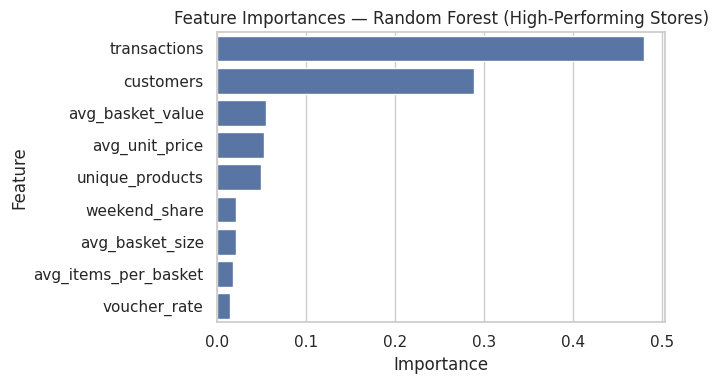

Top high-performing supermarkets (ranked by model probability):

    supermarket   revenue  rf_prob_high_perf  high_perf
0           359  17138.56             1.0000          1
1           321  11537.89             1.0000          1
2           326  16454.28             1.0000          1
3           285   9698.09             1.0000          1
4           259  12667.78             1.0000          1
..          ...       ...                ...        ...
95          164   7948.13             0.2950          0
96          101   7042.43             0.2775          0
97          113   7210.28             0.2675          0
98          128   7168.21             0.2625          0
99          116   8266.82             0.2625          0

[100 rows x 4 columns]

High-performing supermarket IDs:
 {5, 9, 16, 17, 23, 27, 32, 33, 35, 37, 40, 52, 54, 66, 69, 71, 78, 91, 92, 97, 103, 107, 109, 112, 126, 135, 139, 154, 162, 172, 174, 176, 184, 186, 190, 191, 193, 196, 207, 215, 217, 227, 234, 235, 240, 

In [50]:
# === Supermarket-level high-performer classifier  ===

# checking: computing line-level revenue to be robust if amount is unit price
sales = sales.assign(line_revenue=sales["amount"] * sales["units"])

# checking: base aggregation at store level
supermarket_perf = (
    sales.groupby("supermarket")
         .agg(
             transactions=("basket", "nunique"),
             customers=("customer_id", "nunique"),
             units=("units", "sum"),
             revenue=("line_revenue", "sum")
         )
         .reset_index()
)

# checking: core derived features
supermarket_perf["avg_basket_size"] = supermarket_perf["units"] / supermarket_perf["transactions"].clip(lower=1)
supermarket_perf["avg_basket_value"] = supermarket_perf["revenue"] / supermarket_perf["transactions"].clip(lower=1)

# checking: quick store-level enrichments from line data
# weekend share (fraction of lines that occurred on weekend)
wknd = sales.groupby("supermarket")["is_weekend"].mean().rename("weekend_share")

# voucher rate (fraction of lines with voucher)
vchr = sales.groupby("supermarket")["voucher"].mean().rename("voucher_rate")

# average unit price at the store (mean of amount per unit across lines; guard divide-by-zero)
unit_price_series = (sales["amount"] / sales["units"].clip(lower=1))
avgp = unit_price_series.groupby(sales["supermarket"]).mean().rename("avg_unit_price")

# product breadth (unique SKUs)
uprods = sales.groupby("supermarket")["code"].nunique().rename("unique_products")

# average items per basket at the store (basket composition)
avg_items = (
    sales.groupby(["supermarket", "basket"])["units"].sum()
         .groupby("supermarket").mean()
         .rename("avg_items_per_basket")
)

# checking: merging enrichments
supermarket_perf = (
    supermarket_perf
      .merge(wknd, on="supermarket", how="left")
      .merge(vchr, on="supermarket", how="left")
      .merge(avgp, on="supermarket", how="left")
      .merge(uprods, on="supermarket", how="left")
      .merge(avg_items, on="supermarket", how="left")
)

# checking: defining target (top 25% revenue = high-performing)
revenue_q75 = supermarket_perf["revenue"].quantile(0.75)
supermarket_perf["high_perf"] = (supermarket_perf["revenue"] >= revenue_q75).astype(int)
print("Class balance (0=other, 1=high-perf):\n", supermarket_perf["high_perf"].value_counts(), "\n")

# checking: selecting features for modeling
feat_cols = [
    "transactions", "customers", "avg_basket_size", "avg_basket_value",
    "weekend_share", "voucher_rate", "avg_unit_price",
    "unique_products", "avg_items_per_basket"
]

# checking: preparing X/y (DataFrame to preserve column names)
X = supermarket_perf[feat_cols]
y = supermarket_perf["high_perf"]

# checking: splitting train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# checking: models
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42
)

# checking: fitting
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

# checking: predictions & metrics (Logistic)
y_pred_lr = log_reg.predict(X_test)
y_score_lr = log_reg.predict_proba(X_test)[:, 1]
print("=== Logistic Regression ===")
print("AUC:", round(roc_auc_score(y_test, y_score_lr), 4))
print(classification_report(y_test, y_pred_lr))

# checking: predictions & metrics (Random Forest)
y_pred_rf = rf.predict(X_test)
y_score_rf = rf.predict_proba(X_test)[:, 1]
print("\n=== Random Forest ===")
print("AUC:", round(roc_auc_score(y_test, y_score_rf), 4))
print(classification_report(y_test, y_pred_rf))

# checking: feature importances (RF) — table + bar chart
importance_df = (
    pd.DataFrame({"feature": X_train.columns, "importance": rf.feature_importances_})
      .sort_values("importance", ascending=False)
)
print("\nFeature importances (RF):\n", importance_df.round(4))

plt.figure(figsize=(7, 4))
sns.barplot(x="importance", y="feature", data=importance_df, orient="h")
plt.title("Feature Importances — Random Forest (High-Performing Stores)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# === Identifying high-performing supermarkets ===

# get predicted probabilities for all supermarkets
supermarket_perf["rf_prob_high_perf"] = rf.predict_proba(X)[:, 1]

# sort supermarkets by probability of being high-performer
ranked_supermarkets = (
    supermarket_perf[["supermarket", "revenue", "rf_prob_high_perf", "high_perf"]]
    .sort_values("rf_prob_high_perf", ascending=False)
    .reset_index(drop=True)
)

print("Top high-performing supermarkets (ranked by model probability):\n")
print(ranked_supermarkets.head(100))  # show top 20

# set of supermarket IDs predicted as high-performers
high_perf_ids = set(
    ranked_supermarkets[ranked_supermarkets["high_perf"] == 1]["supermarket"]
)
print("\nHigh-performing supermarket IDs:\n", high_perf_ids)
